In [0]:
!pip install catboost

     |████████████████████████████████| 62.9MB 35kB/s 


In [0]:

%matplotlib inline
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('/content/train_2017.csv')
test = pd.read_csv('/content/test.csv')
gender_submission = pd.read_csv('/content/gender_submission.csv') # example of what a submission should look like

In [0]:

train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


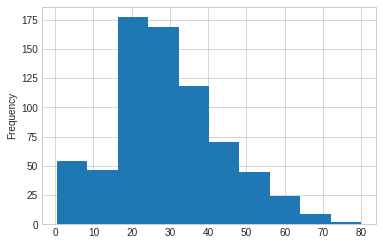

In [0]:
train.Age.plot.hist()

In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


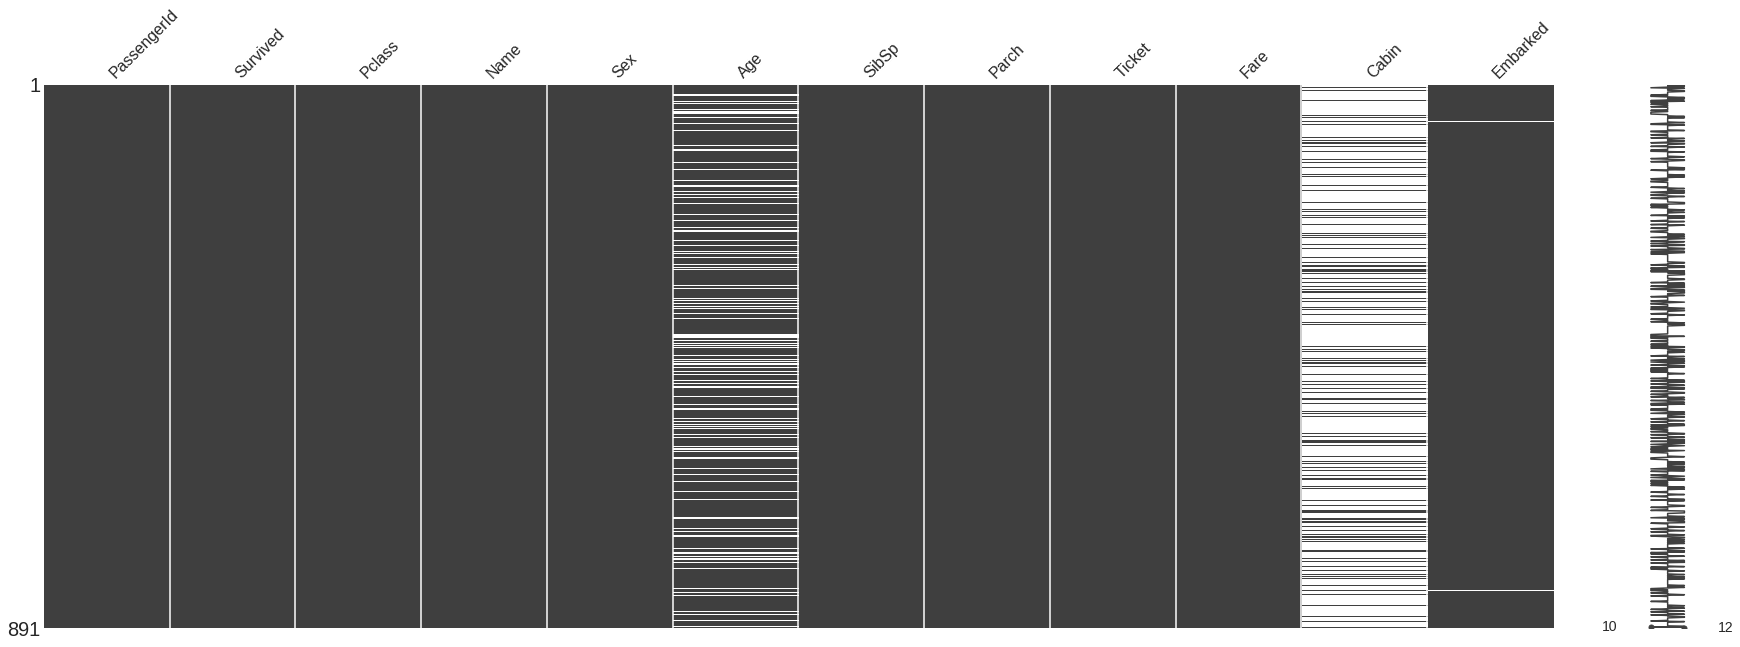

In [0]:
missingno.matrix(train, figsize = (30,10))

In [0]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
df_bin = pd.DataFrame() 
df_con = pd.DataFrame() 

In [0]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


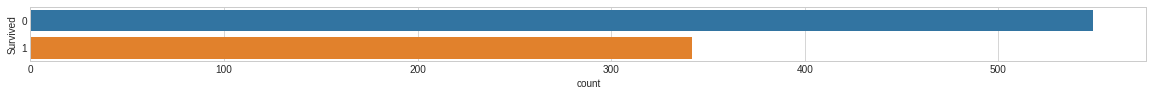

In [0]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [0]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [0]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [0]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


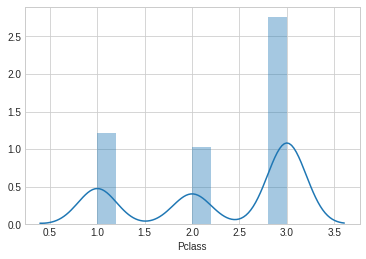

In [0]:
sns.distplot(train.Pclass)

In [0]:
train.Pclass.isnull().sum()

0

In [0]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [0]:
train.Name.value_counts()

Wheadon, Mr. Edward H                                   1
Slemen, Mr. Richard James                               1
Reeves, Mr. David                                       1
Angle, Mrs. William A (Florence "Mary" Agnes Hughes)    1
Crosby, Capt. Edward Gifford                            1
                                                       ..
Silverthorne, Mr. Spencer Victor                        1
Jonsson, Mr. Carl                                       1
Graham, Mr. George Edward                               1
Coutts, Master. Eden Leslie "Neville"                   1
Hickman, Mr. Lewis                                      1
Name: Name, Length: 891, dtype: int64

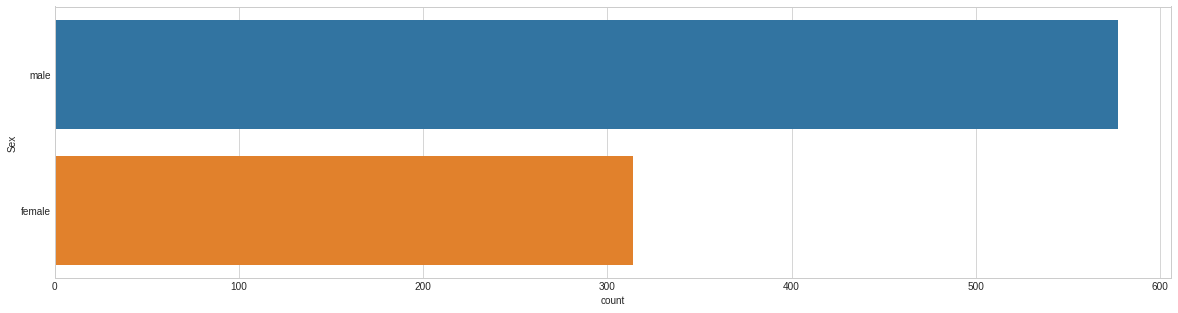

In [0]:
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [0]:
train.Sex.isnull().sum()

0

In [0]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [0]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) 

df_con['Sex'] = train['Sex']

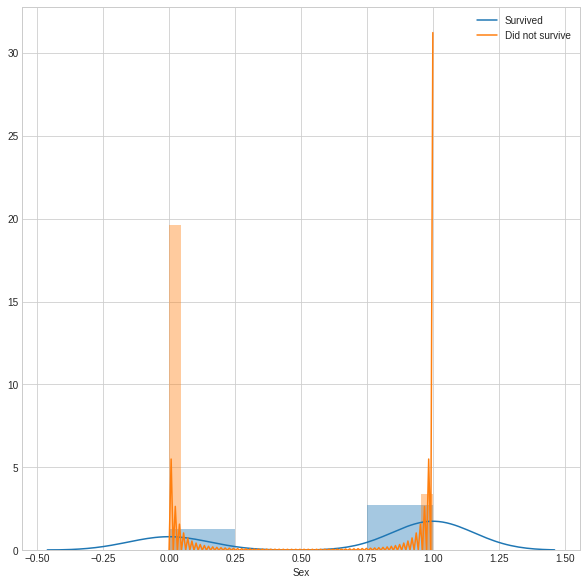

In [0]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

In [0]:
train.Age.isnull().sum()

177

In [0]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

In [0]:
train.SibSp.isnull().sum()

0

In [0]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [0]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

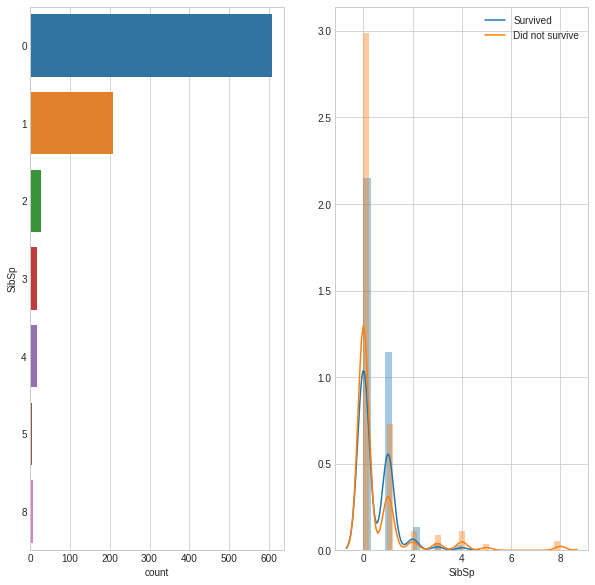

In [0]:
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(10, 10))

In [0]:
train.Ticket.isnull().sum()

0

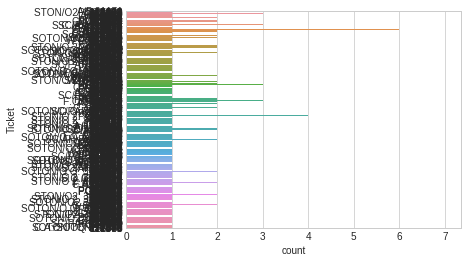

In [0]:
sns.countplot(y="Ticket", data=train);

In [0]:
train.Ticket.value_counts()

CA. 2343    7
347082      7
1601        7
347088      6
3101295     6
           ..
12233       1
2648        1
349224      1
250643      1
2667        1
Name: Ticket, Length: 681, dtype: int64

In [0]:
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


In [0]:
train.Fare.isnull().sum()

0

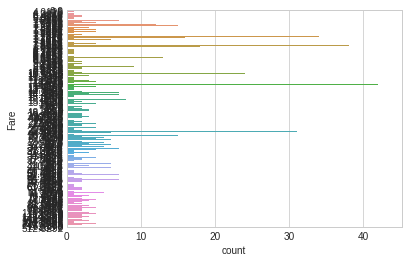

In [0]:
sns.countplot(y="Fare", data=train);

In [0]:
train.Fare.dtype

dtype('float64')

In [0]:
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


In [0]:
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [0]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

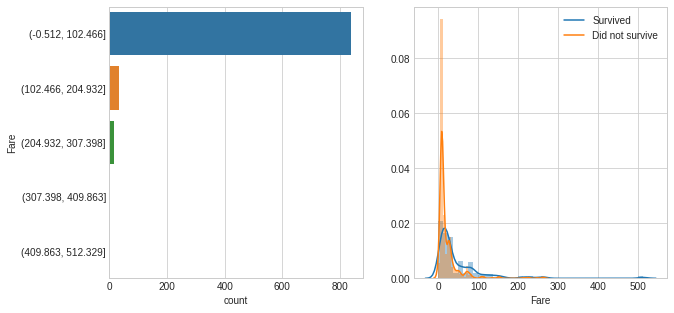

In [0]:
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(10,5), 
                use_bin_df=True)

In [0]:
train.Cabin.isnull().sum()

687

In [0]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
train.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
D              3
F33            3
              ..
D10 D12        1
C91            1
A10            1
A14            1
E34            1
Name: Cabin, Length: 147, dtype: int64

In [0]:
train.Embarked.isnull().sum()

2

In [0]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

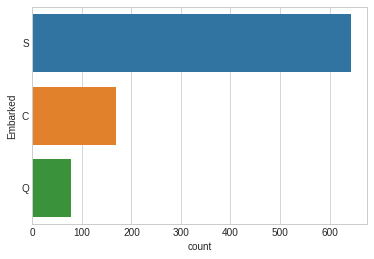

In [0]:
sns.countplot(y='Embarked', data=train);

In [0]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [0]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


In [0]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,0,3,0,1,"(-0.512, 102.466]",S
1,1,1,1,1,"(-0.512, 102.466]",C
2,1,3,1,0,"(-0.512, 102.466]",S
3,1,1,1,1,"(-0.512, 102.466]",S
4,0,3,0,0,"(-0.512, 102.466]",S


In [0]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [0]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,0,3,male,1,7.2500,S
1,1,1,female,1,71.2833,C
2,1,3,female,0,7.9250,S
3,1,1,female,1,53.1000,S
4,0,3,male,0,8.0500,S
5,0,3,male,0,8.4583,Q
6,0,1,male,0,51.8625,S
7,0,3,male,3,21.0750,S
8,1,3,female,0,11.1333,S
9,1,2,female,1,30.0708,C


In [0]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [0]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [0]:
df_con_enc.head(20)

,Survived,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,7.2500,0,0,1,0,1,0,0,1
1,1,1,71.2833,1,0,0,1,0,1,0,0
2,1,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,21.0750,0,0,1,0,1,0,0,1
8,1,0,11.1333,0,0,1,1,0,0,0,1
9,1,1,30.0708,1,0,0,1,0,0,1,0


In [0]:
selected_df = df_con_enc

In [0]:
selected_df.head()

,Survived,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,7.2500,0,0,1,0,1,0,0,1
1,1,1,71.2833,1,0,0,1,0,1,0,0
2,1,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [0]:
X_train = selected_df.drop('Survived', axis=1)
y_train = selected_df.Survived 

In [0]:
X_train.shape

(889, 10)

In [0]:
X_train.head()

,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,7.2500,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,0,1,0,1,0,0
2,0,7.9250,0,0,1,1,0,0,0,1
3,1,53.1000,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,1,0,1,0,0,1


In [0]:
y_train.shape

(889,)

In [0]:
def fit_ml_algo(algo, X_train, y_train, cv):
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2) 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, acc, acc_cv

In [0]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.87
Accuracy CV 10-Fold: 79.19
Running Time: 0:00:02.158779


In [0]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.35
Accuracy CV 10-Fold: 76.49
Running Time: 0:00:02.010930


In [0]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.97
Accuracy CV 10-Fold: 78.07
Running Time: 0:00:01.962887


In [0]:
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 79.19
Accuracy CV 10-Fold: 78.74
Running Time: 0:00:02.262806


In [0]:
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 70.75
Accuracy CV 10-Fold: 68.17
Running Time: 0:00:02.036149


In [0]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.01
Accuracy CV 10-Fold: 81.33
Running Time: 0:00:02.020493


In [0]:
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.73
Accuracy CV 10-Fold: 81.55
Running Time: 0:00:02.736522


In [0]:
X_train.head()

,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,7.2500,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,0,1,0,1,0,0
2,0,7.9250,0,0,1,1,0,0,0,1
3,1,53.1000,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,1,0,1,0,0,1


In [0]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [0]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [0]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [0]:
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')
catboost_model.fit(train_pool,
                   plot=True)
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.016206


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6828710	total: 68.5ms	remaining: 1m 8s
1:	learn: 0.6726384	total: 88.6ms	remaining: 44.2s
2:	learn: 0.6635068	total: 103ms	remaining: 34.1s
3:	learn: 0.6547441	total: 119ms	remaining: 29.6s
4:	learn: 0.6461124	total: 144ms	remaining: 28.7s
5:	learn: 0.6378662	total: 198ms	remaining: 32.8s
6:	learn: 0.6296202	total: 223ms	remaining: 31.6s
7:	learn: 0.6215742	total: 236ms	remaining: 29.3s
8:	learn: 0.6144001	total: 243ms	remaining: 26.8s
9:	learn: 0.6095915	total: 252ms	remaining: 24.9s
10:	learn: 0.6028180	total: 259ms	remaining: 23.3s
11:	learn: 0.5958794	total: 266ms	remaining: 21.9s
12:	learn: 0.5914400	total: 269ms	remaining: 20.4s
13:	learn: 0.5861666	total: 279ms	remaining: 19.6s
14:	learn: 0.5825336	total: 283ms	remaining: 18.6s
15:	learn: 0.5785193	total: 290ms	remaining: 17.8s
16:	learn: 0.5752420	total: 294ms	remaining: 17s
17:	learn: 0.5693103	total: 301ms	remaining: 16.4s
18:	learn: 0.5635128	total: 308ms	remaining: 15.9s
19:	learn: 0.5588433	total: 316ms	remaini

In [0]:
start_time = time.time()

cv_params = catboost_model.get_params()

cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

catboost_time = (time.time() - start_time)
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6745582	test: 0.6749316	best: 0.6749316 (0)	total: 374ms	remaining: 6m 13s
1:	learn: 0.6590356	test: 0.6594897	best: 0.6594897 (1)	total: 659ms	remaining: 5m 29s
2:	learn: 0.6425433	test: 0.6435276	best: 0.6435276 (2)	total: 971ms	remaining: 5m 22s
3:	learn: 0.6308039	test: 0.6322396	best: 0.6322396 (3)	total: 1.26s	remaining: 5m 14s
4:	learn: 0.6175688	test: 0.6199471	best: 0.6199471 (4)	total: 1.57s	remaining: 5m 12s
5:	learn: 0.6056308	test: 0.6088909	best: 0.6088909 (5)	total: 1.87s	remaining: 5m 10s
6:	learn: 0.5938492	test: 0.5979255	best: 0.5979255 (6)	total: 2.17s	remaining: 5m 8s
7:	learn: 0.5824140	test: 0.5872374	best: 0.5872374 (7)	total: 2.48s	remaining: 5m 7s
8:	learn: 0.5723305	test: 0.5779409	best: 0.5779409 (8)	total: 2.78s	remaining: 5m 6s
9:	learn: 0.5628827	test: 0.5695129	best: 0.5695129 (9)	total: 3.08s	remaining: 5m 4s
10:	learn: 0.5542585	test: 0.5613450	best: 0.5613450 (10)	total: 3.36s	remaining: 5m 2s
11:	learn: 0.5460277	test: 0.5535334	best: 0.5

In [0]:
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 86.28
Accuracy cross-validation 10-Fold: 81.55
Running Time: 0:05:07.087687


In [0]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.01
6,Gradient Boosting Trees,86.73
7,CatBoost,86.28
0,KNN,83.35
1,Logistic Regression,79.87
4,Linear SVC,79.19
2,Naive Bayes,78.97
3,Stochastic Gradient Decent,70.75


In [0]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,81.55
7,CatBoost,81.55
5,Decision Tree,81.33
1,Logistic Regression,79.19
4,Linear SVC,78.74
2,Naive Bayes,78.07
0,KNN,76.49
3,Stochastic Gradient Decent,68.17


In [0]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
3,1.158160,embarked_Q
7,2.201932,pclass_1
8,2.289204,pclass_2
2,2.811194,embarked_C
4,2.847100,embarked_S
9,10.271353,pclass_3
0,14.511136,SibSp
5,16.812640,sex_female
6,19.207333,sex_male
1,27.889948,Fare


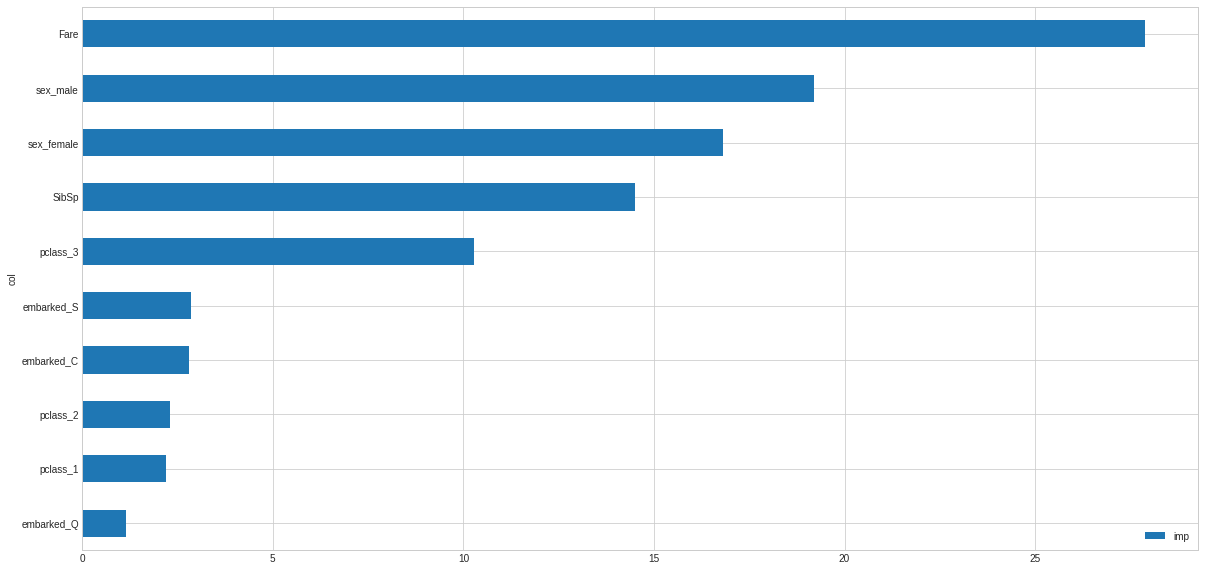

In [0]:
feature_importance(catboost_model, X_train)

In [0]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8563377622953853
Recall: 0.6754823529411765
F1: 0.7550812222079303
AUC: 0.8928636049501768


In [0]:
X_train.head()

,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,7.2500,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,0,1,0,1,0,0
2,0,7.9250,0,0,1,1,0,0,0,1
3,1,53.1000,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,1,0,1,0,0,1


In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [0]:
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [0]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female',
       'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [0]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [0]:
predictions[:20]

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1.])

In [0]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions 
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [0]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [0]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [0]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [0]:
submission.to_csv('kishan.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [0]:
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
